<a href="https://colab.research.google.com/github/drorjac/PyNNcml_EE/blob/main/MRG_Data_Driven_PyNNCML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# End-To-End Training Example of RNN for rain estimation and detection using PyNNCML
This notebook presents an end-to-end example of training a Recurrent Neural Network (RNN) based rain estimation neural network [1] on the openMRG dataset.
This tutorial is built using the PyNNCML software package, which provides both tools to simplify the training process of deep learning models for CMLs.
We start with obtaining a subset of the OpenMRG dataset and splitting it into training and validation datasets.
Afterward, we construct the One Step Network from [1], followed by the training loop.
Finally, we analyze the model performance in terms of RMSE and Bias.


Notebook structure
1. Imports and Installation of PyNNCML
2. Hyperparameter settings
3. Build Dataset
4. Build Neural Network
5. Training Loop
6. Neural Network Analysis


[Run this notebook in colab](https://colab.research.google.com/github/haihabi/PyNNcml/blob/main/examples/tutorial/data_driven.ipynb)

To run this notebook on Colab using GPU, please do the following:
Runtime -> Change runtime type -> Select GPU -> Save


In [ ]:
%load_ext autoreload
%autoreload 2

import sys
import os

# Ensure the correct repository is used
repo_url = "https://github.com/drorjac/PyNNcml_EE.git"
repo_dir = "../PyNNcml_EE"
package_dir = os.path.join(repo_dir, "pynncml")

if os.path.exists(package_dir):
    print("Import PyNNCML From Cloned Repository")
    sys.path.append(repo_dir)
else:
    print("Cloning PyNNCML from GitHub")
    !rm -rf {repo_dir}  # Remove any existing incorrect version
    !git clone {repo_url} {repo_dir}
    sys.path.append(repo_dir)

# Install dependencies
!pip install --upgrade huggingface_hub
!pip install huggingface_hub==0.11.1
!pip install -e {repo_dir}

import numpy as np
import pynncml as pnc
import torch
import math
from matplotlib import pyplot as plt
from tqdm import tqdm
import scipy
from sklearn import metrics


Cloning PyNNCML from GitHub
Cloning into '../PyNNcml_EE'...
remote: Enumerating objects: 1406, done.
remote: Counting objects: 100% (226/226), done.
remote: Compressing objects: 100% (167/167), done.
remote: Total 1406 (delta 154), reused 81 (delta 58), pack-reused 1180 (from 1)
Receiving objects: 100% (1406/1406), 7.30 MiB | 15.22 MiB/s, done.
Resolving deltas: 100% (883/883), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.1/468.1 kB 22.4 MB/s eta 0:00:00
  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface-hub 0.28.1
    Uninstalling huggingface-hub-0.28.1:
      Successfully uninstalled huggingface-hub-0.28.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 kB 8.5 MB/s eta 0:00:00
  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface-hub 0.29.2
    Uninstalling huggingface-hub-0.29.2:
      Successfully uninstalled huggingface-hub-0.29.2
ERROR: pip's dependency resolver does not currently take into account 

In [ ]:
# @title tons of functions
import pandas as pd
import numpy as np
import scipy as sp
import netCDF4
from netCDF4 import Dataset
import geopy.distance
import io
import ast
import re
import glob
import matplotlib.pyplot as plt
import pickle
import math
from geopy.distance import geodesic

# @title map functions
import pandas as pd
import folium
from math import radians, cos, sqrt
import matplotlib.dates
import matplotlib.dates as mdates
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import ipywidgets as widgets
from IPython.display import display


p_sweden = ( 57.70368 ,	11.99507)

min_val = 10
bucket_size = 5
M = 8
frq_intervals = [(min_val + i * bucket_size, min_val + (i + 1) * bucket_size) for i in range(M)]
colors = [
    '#0000FF',  # Blue
    '#006400',  # Dark Green
    '#8B0000',  # Dark Red
    '#008B8B',  # Dark Cyan
    '#2F4F4F',  # Dark Slate Gray
    '#556B2F',  # Dark Olive Green
    '#8B4513',  # Saddle Brown
    '#5E2605',  # Dark Brown
    '#483D8B',  # Dark Slate Blue (Not too purple)
    '#2E8B57'   # Sea Green
]

def display_map(latitude, longitude):
    # Create a map centered at the given coordinates
    m = folium.Map(location=[latitude, longitude], zoom_start=13 , width='50%', height='50%')
    # Add a marker at the given coordinates
    folium.Marker([latitude, longitude]).add_to(m)
    # Display the map
    return m

def display_map_with_line(lat1, lon1, lat2, lon2):
    # Create a map centered at the midpoint of the given coordinates
    m = folium.Map( location = [ ( lat1 + lat2 ) / 2, (lon1 + lon2) / 2], zoom_start=13)
    # Add markers at the given coordinates
    folium.Marker([lat1, lon1]).add_to(m)
    folium.Marker([lat2, lon2]).add_to(m)
    # Draw a line between the coordinates
    folium.PolyLine([(lat1, lon1), (lat2, lon2)], color="blue").add_to(m)
    # Display the map
    return m


def add_point_to_map(m, latitude, longitude, tooltip_text = 'Point'):
    """
    Add a point to an existing folium map.

    Args:
        m (folium.Map): The existing map to which the point will be added.
        latitude (float): The latitude of the point.
        longitude (float): The longitude of the point.
        tooltip_text (str, optional): The tooltip text when hovering over the point. Defaults to 'Point'.

    Returns:
        None: The function modifies the existing map in place.
    """
    # Create a tooltip with custom HTML to set the text size
    tooltip = folium.Tooltip(f'<span style="font-size: 18px;">{tooltip_text}</span>')

    # Add a marker at the given coordinates with the tooltip
    folium.Marker(
          [latitude, longitude],
          tooltip=tooltip,
          icon=folium.Icon(color='red', icon='circle', prefix='fa')  # 'fa' stands for Font Awesome
      ).add_to(m)

def add_line_to_map(m, row , txt='Try Text'):
    sublink = row['Sublink']
    lat1, lon1 = (row['NearLatitude_DecDeg'], row['NearLongitude_DecDeg']) # (x,y)
    lat2, lon2 = (row['FarLatitude_DecDeg'], row['FarLongitude_DecDeg'])
    frq =   row['Frequency_GHz']

    # Create popups with coordinates
    popup1 = folium.Popup(f"Coordinates: {lat1}, {lon1}", parse_html=True)
    popup2 = folium.Popup(f"Coordinates: {lat2}, {lon2}", parse_html=True)

    # Add CircleMarkers with popups
    folium.CircleMarker([lat1, lon1], radius=4, color='black', popup=popup1).add_to(m)
    folium.CircleMarker([lat2, lon2], radius=4, color='black', popup=popup2).add_to(m)

    # sublink = row['Sublink']
    # lat1, lon1 = (row['NearLatitude_DecDeg'], row['NearLongitude_DecDeg']) # (x,y)
    # lat2, lon2 = (row['FarLatitude_DecDeg'], row['FarLongitude_DecDeg'])
    # frq =   row['Frequency_GHz']
    # small_icon = folium.Icon(icon_size=(10, 10))
    # #####
    # folium.CircleMarker([lat1, lon1], radius=4, color='black').add_to(m)
    # folium.CircleMarker([lat2, lon2], radius=4, color='black').add_to(m)

    ###
    # Midpoint of the line
    mid_lat, mid_lon = (lat1 + lat2) / 2, (lon1 + lon2) / 2

    # Tooltip with custom HTML to set the text size

    bucket = into_bucket(frq , frq_intervals)
    txt = str(bucket)
    txt = str(sublink) + ' , ' + txt
    tooltip = folium.Tooltip(f'<span style="font-size: 18px;">{txt}</span>')

    # Create the polyline with the tooltip
    line = folium.PolyLine(
        [(lat1, lon1), (lat2, lon2)],
        color= colors[bucket] ,
        tooltip=tooltip
    )

    # Add the line to the map
    line.add_to(m)


################################################################################

def display_map_with_line(lat1, lon1, lat2, lon2):
    # Create a map centered at the midpoint of the given coordinates
    m = folium.Map( location = [ ( lat1 + lat2 ) / 2, (lon1 + lon2) / 2], zoom_start=13)
    # Add markers at the given coordinates
    folium.Marker([lat1, lon1]).add_to(m)
    folium.Marker([lat2, lon2]).add_to(m)
    # Draw a line between the coordinates
    folium.PolyLine([(lat1, lon1), (lat2, lon2)], color="blue").add_to(m)
    # Display the map
    return m


def create_map(  p_center = p_sweden ):
    latitude, longitude = p_center

    return folium.Map(location=[latitude, longitude], zoom_start=13)

# @title map functions
from geopy.distance import geodesic


def create_map_sweden(df , m_map = None):
  if m_map == None:
    m_map = create_map()
  for index, row in df.iterrows():
    sublink = row['Sublink']
    add_line_to_map(m_map ,row)
  return m_map


def calculate_distance(point1, point2):
    """
    Calculate the distance between two points on the Earth's surface
    using the geopy package.

    Args:
        point1 (tuple): Latitude and longitude of point 1 as a tuple (lat, lon).
        point2 (tuple): Latitude and longitude of point 2 as a tuple (lat, lon).

    Returns:
        float: Distance between the two points in kilometers.
    """
    distance = geodesic(point1, point2).kilometers
    return distance

def line_to_points(start, end, num_points):
    """
    Splits the line into num_points and returns a list of these points.
    Args:
        start (tuple): Latitude and longitude of the start point (lat, lon).
        end (tuple): Latitude and longitude of the end point (lat, lon).
        num_points (int): Number of points to split the line into.

    Returns:
        list: List of tuples representing points (lat, lon).
    """
    points = []
    for i in range(num_points):
        t = i / float(num_points - 1)
        lat = (1 - t) * start[0] + t * end[0]
        lon = (1 - t) * start[1] + t * end[1]
        points.append((lat, lon))
    return points

from geopy.distance import geodesic

def calculate_distance(point1, point2):
    """
    Calculate the distance between two points on the Earth's surface
    using the geopy package.

    Args:
        point1 (tuple): Latitude and longitude of point 1 as a tuple (lat, lon).
        point2 (tuple): Latitude and longitude of point 2 as a tuple (lat, lon).

    Returns:
        float: Distance between the two points in kilometers.
    """
    distance = geodesic(point1, point2).kilometers
    return distance

def average_distance_point_to_line(point, line):
    """
    Calculate the average distance from a point to points along a line.

    Args:
        point (tuple): Latitude and longitude of the target point as a tuple (lat, lon).
        line (list): List of tuples, each representing the latitude and longitude of a point on the line.

    Returns:
        float: Average distance in kilometers from the point to the points on the line.
    """
    total_distance = 0
    num_points = len(line)

    for line_point in line:
        distance = calculate_distance(line_point, point)
        total_distance += distance

    average_distance = total_distance / num_points
    return average_distance

# @title plot functions

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express as px

def plot_time_series(df, time_col, y_cols=None, interval=None, time_format='day', y_label="Data", filter=False, legend_label='Data Signals', color='tab:blue'):
    """
    Plot a time series data, which can be multivariate.

    Args:
        df (DataFrame): DataFrame for the plot.
        time_col (str): Time column in df.
        y_cols (list): List of columns to plot.
        interval (tuple): Start and end datetime for filtering.
        time_format (str): Format of the time axis ('day' or 'hour:min').
        y_label (str): Label for the y-axis.
        filter (bool): Apply causal moving average filter if True.
    """
    # Convert the time column to datetime
    df[time_col] = pd.to_datetime(df[time_col])

    # Filter dataframe based on the interval
    if interval:
        start_date, end_date = interval
        df = filter_dataframe(df, time_col, start_date, end_date)

    # Create the figure
    fig, ax = plt.subplots(figsize=(8, 6))

    # Plotting for the time series
    if not y_cols:
        y_cols = [col for col in df.columns if col != time_col]

    for col in y_cols:
        y = df[col]
        if filter:
            y = causal_moving_average(y, window_size=3)
        ax.plot(df[time_col], y, label=col, color=color)

    ax.grid(True, alpha=0.3)
    ax.set_ylabel(y_label, fontsize=12)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.set_xlabel('Time', fontsize=12)

    # Format the x-axis dates
    locator = mdates.AutoDateLocator()
    if time_format == 'hour:min':
        formatter = mdates.DateFormatter('%H:%M')
    else:
        formatter = mdates.AutoDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)

    # Custom legend
    custom_legend = mlines.Line2D([], [], color=color, label=legend_label)
    ax.legend(handles=[custom_legend])

    # Automatically adjust the x-axis labels and layout
    fig.autofmt_xdate()
    plt.tight_layout()

    # Show the plot
    plt.show()

def plot_2d_histogram_matplotlib(x, y, x_bins=30, y_bins=30):
    plt.hist2d(x, y, bins=(x_bins, y_bins), cmap=plt.cm.jet)
    plt.colorbar()
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title('2D Histogram with Matplotlib')
    plt.show()


def plot_hexbin_seaborn(x, y):
    sns.jointplot(x=x, y=y, kind='hex')
    plt.show()

# Sample usage


def plot_2d_histogram_plotly(x, y, x_bins=30, y_bins=30):
    df = pd.DataFrame({'x': x, 'y': y})
    fig = px.density_heatmap(df, x='x', y='y', nbinsx=x_bins, nbinsy=y_bins, color_continuous_scale='Jet')
    fig.show()

def plot_3d_scatter_matplotlib(x, y, z):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(x, y, z)

    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('Z-axis')
    plt.title('3D Scatter Plot with Matplotlib')

    plt.show()

# Sample usage


def plot_color_labels_row(colors, labels):
    """
    Plots colored markers with corresponding text labels in a vertical layout.

    Parameters:
        colors (list): List of color names.
        labels (list): List of labels for each color.
    """
    if len(colors) != len(labels):
        print("Length of colors and labels lists must be the same.")
        return

    plt.figure(figsize=(2, 4))  # Reduced width to minimize horizontal space

    for i, (color, label) in enumerate(zip(colors, labels)):
        plt.scatter(0, i, s=200, c=color)
        plt.text(0.1, i, label, ha='left', va='center', fontsize=14)  # Increased text size

    plt.axis('off')
    plt.gca().invert_yaxis()  # Invert y-axis for top-to-bottom legend
    plt.tight_layout()  # Minimizes extra space within the plot
    plt.show()

# Example usage
# colors = ["darkgray", "navy", "teal", "maroon", "darkorange", "crimson", "red"]

def plot_color_labels(colors, labels):
    """
    Plots colored markers with corresponding text labels in a 2-column layout.

    Parameters:
        colors (list): List of color names.
        labels (list): List of labels for each color.
    """
    if len(colors) != len(labels):
        print("Length of colors and labels lists must be the same.")
        return

    plt.figure(figsize=(6, 4))  # Adjusted figure size to accommodate two columns

    for i, (color, label) in enumerate(zip(colors, labels)):
        row = i // 2  # Determine which row to plot on
        col = i % 2   # Determine which column to plot on

        x = col * 0.3  # x-position (0 or 0.5 to create two columns)
        y = row  # y-position

        plt.scatter(x, y, s=200, c=color)
        # plt.text(x + 0.1, y, label, ha='left', va='center', fontsize=14)  # Increased text size
        plt.text(x + 0.03, y, label, ha='left', va='center', fontsize=24)
    plt.axis('off')
    plt.gca().invert_yaxis()  # Invert y-axis for top-to-bottom legend
    plt.tight_layout()  # Minimizes extra space within the plot
    plt.show()

def plot_color_labels(colors, labels):
    """
    Plots colored markers with corresponding text labels in a 2-column layout.

    Parameters:
        colors (list): List of color names.
        labels (list): List of labels for each color.
    """
    if len(colors) != len(labels):
        print("Length of colors and labels lists must be the same.")
        return

    plt.figure(figsize=(6, 4))  # Adjusted figure size for better visibility

    for i, (color, label) in enumerate(zip(colors, labels)):
        row = i // 2  # Determine which row to plot on
        col = i % 2   # Determine which column to plot on

        x = col * 0.02  # Adjusted x-position to decrease horizontal space
        y = row * 0.0002  # Adjusted y-position to decrease vertical space

        plt.scatter(x, y, s=500, c=color)  # Increased marker size
        plt.text(x + 0.001, y, label, ha='left', va='center', fontsize=20)  # Increased text size

    plt.axis('off')
    plt.gca().invert_yaxis()  # Invert y-axis for top-to-bottom legend
    plt.tight_layout(pad=0)  # Minimized extra space within the plot with pad=0
    plt.show()

def plt_pred(label , pred , error = 1):
  plt.plot(pred , label = 'rg')
  plt.plot(label , label = 'link PL')

  plt.legend()
  plt.show()
  if error:
    error = np.array(label) - np.array(pred)
    rmse = np.sqrt(np.mean((error)**2))
    plt.plot(error ,  label = f'rmse = {rmse}')
    plt.legend()



def plot_side_by_side(data1, data2, titles = ['' , ''], x_labels ='', y_labels=''):
    """
    Plots two datasets side by side.

    Args:
    data1, data2 (tuple): Tuples containing x and y data points, e.g., (x1, y1) and (x2, y2)
    titles (list): Titles for the two plots.
    x_labels, y_labels (list): Labels for the x and y axes.
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # You can adjust the figure size

    # Plotting the first dataset
    axes[0].plot(data1[0], data1[1])
    axes[0].set_title(titles[0])
    axes[0].set_xlabel(x_labels[0])
    axes[0].set_ylabel(y_labels[0])
    axes[0].grid(True)  # Adding grid

    # Plotting the second dataset
    axes[1].plot(data2[0], data2[1])
    axes[1].set_title(titles[1])
    axes[1].set_xlabel(x_labels[1])
    axes[1].set_ylabel(y_labels[1])
    axes[1].grid(True)  # Adding grid

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

# @title rain_related functions
def r_power_law(att_ts , a, b , L ):
  # calculate rain rate from attenuation
  r_t =  (att_ts / (a*L))**(1/b)
  return r_t

def apply_r_power_law(df1, df2, col1, col2, a, b, L):
    df1[f'{col1}_r_power_law'] = r_power_law(df1[col1], a, b, L)
    df2[f'{col2}_r_power_law'] = r_power_law(df2[col2], a, b, L)
    return df1, df2

def rain_event_detector_n( raw_gauges ,   min_event_time = 10 , stop_index = 5):
  '''
  We created a dictionary that contains for each rain gauge its indexes for
  rain intervals. We defined rain event as an event that lasts at least
  10 minutes and there is 15 minutes gap of dry indexes for each gauge
  '''
  #the minutes after the rain stop that need be recognaized as wet (for rain guages)
  RG_rain_indexes = {}
  for gauge in raw_gauges.columns[1:]:
    RG_rain_indexes[gauge] = []
  #adds all the gauge names to the array
  RG_Names = list(raw_gauges.columns[1:])

  for gauge_name in RG_rain_indexes.keys():
    start_now=False # detect rain flag
    dry_days_count=0
    current_gauge_data = raw_gauges[gauge_name]
    data_size = len(current_gauge_data)
    for index in range(data_size):
      # means there is rain
      if current_gauge_data[index] > 0:
        dry_days_count = 0
        if start_now ==False:    #saves the start time of the rain event
          start_time =  index
          start_now = True
      #means that there is no rain
      elif dry_days_count < stop_index and start_now==True:  # non-rain
      # block to end rain event
        dry_days_count += 1
      #needs to insert the dates into the dictionary
      if dry_days_count==stop_index:
          #saves the end time of the rain event
            end_time = index
            event_tuple = (start_time,end_time)
            start_now=False
            dry_days_count=0
            #insert the dates into the dictionary
            RG_rain_indexes[gauge_name].append(event_tuple)

  ########## filter rain event #######
  filter_rain  = stop_index + min_event_time
  for gauge_name in RG_rain_indexes.keys():
    # print(RG_rain_indexes[])
    event_list = RG_rain_indexes[gauge_name]
    for event in event_list:
      # length of rain event
      rain_len = event[1] - event[0]
      if rain_len < filter_rain:
        RG_rain_indexes[gauge_name].remove(event)



  #lengths after filter rain event
  # print("----Number of rain events for each gauge---")
  # for key, value in RG_rain_indexes.items():
    # print(len(RG_rain_indexes[key]))
  return RG_rain_indexes


def a_b(f_GHz, pol, approx_type="ITU"):
    """Approximation of parameters for A-R relationship

    Parameters
    ----------
    f_GHz : int, float or np.array of these
            Frequency of the microwave link in GHz
    pol : str
            Polarization of the microwave link
    approx_type : str, optional
            Approximation type (the default is 'ITU', which implies parameter
            approximation using a table recommanded by ITU)

    Returns
    -------
    a,b : float
          Parameters of A-R relationship

    Note
    ----
    The frequency value must be between 1 Ghz and 100 GHz.

    The polarization has to be indicated by 'h' or 'H' for horizontal and
    'v' or 'V' for vertical polarization respectively.

    Currently only 'ITU' for approx_type is accepted. The approximation makes
    use of a table recommanded by ITU [4]_.

    References
    ----------
    .. [4] ITU, "ITU-R: Specific attenuation model for rain for use in
        prediction methods", International Telecommunication Union, 2013

    """
    from scipy.interpolate import interp1d

    f_GHz = np.asarray(f_GHz)

    if f_GHz.min() < 1 or f_GHz.max() > 100:
        raise ValueError("Frequency must be between 1 Ghz and 100 GHz.")
    else:
        if pol == "V" or pol == "v":
            f_a = interp1d(ITU_table[0, :], ITU_table[2, :], kind="cubic")
            f_b = interp1d(ITU_table[0, :], ITU_table[4, :], kind="cubic")
        elif pol == "H" or pol == "h":
            f_a = interp1d(ITU_table[0, :], ITU_table[1, :], kind="cubic")
            f_b = interp1d(ITU_table[0, :], ITU_table[3, :], kind="cubic")
        else:
            raise ValueError("Polarization must be V, v, H or h.")
        a = f_a(f_GHz)
        b = f_b(f_GHz)
    return a, b

from typing import List, Dict, Tuple
import pandas as pd

def filter_events(events: List[Tuple[int, int]], min_duration: int) -> List[Tuple[int, int]]:
    """Filter out events shorter than the minimum duration.

    Args:
        events: List of start and end indices of detected events.
        min_duration: Minimum duration required for a valid event.

    Returns:
        Filtered list of events.
    """
    return [event for event in events if event[1] - event[0] >= min_duration]

def identify_rain_events(gauge_data: pd.Series, stop_index: int ) -> List[Tuple[int, int]]:
    """Identify rain events for a single gauge.

    Args:
        gauge_data: The time series data for a single rain gauge.
        stop_index: Number of dry intervals to stop a rain event.

    Returns:
        List of start and end indices of detected rain events.
    """
    events = []
    start_event = None  # Variable to hold the starting index of a rain event
    dry_count = 0  # Counter for dry intervals

    for index, value in enumerate(gauge_data):
        # Detect rain
        if value > 0:
            dry_count = 0  # Reset dry interval counter
            if start_event is None:
                start_event = index  # Mark the start of a rain event

        # Detect dry interval within a rain event
        elif dry_count < stop_index and start_event is not None:
            dry_count += 1  # Increment dry interval counter

        # End of rain event
        if dry_count == stop_index:
            end_event = index  # Mark the end of a rain event
            events.append((start_event, end_event))
            start_event = None  # Reset start index for the next event
            dry_count = 0  # Reset dry interval counter

    return events

def rain_event_detector(raw_gauges: pd.DataFrame, min_event_time: int = 10, stop_index: int = 5) -> Dict[str, List[Tuple[int, int]]]:
    """Identify and filter rain events from raw gauge data.

    Args:
        raw_gauges: DataFrame containing the raw gauge data.
        min_event_time: Minimum duration (in time steps) for a valid rain event.
        stop_index: Number of dry time steps required to stop a rain event.

    Returns:
        Dictionary with gauge names as keys and lists of (start, end) indices as values.
    """
    rain_events = {}  # Initialize the dictionary to hold rain events for all gauges

    # Loop through each rain gauge to identify rain events
    for gauge_name in raw_gauges.columns[1:]:
        gauge_data = raw_gauges[gauge_name]
        events = identify_rain_events(gauge_data, stop_index)

        # Filter out events that are shorter than the minimum event time
        filtered_events = filter_events(events, min_event_time + stop_index)

        # Save the filtered events for this gauge
        rain_events[gauge_name] = filtered_events

    return rain_events


def transform_raw_gauges(raw_gauges, W=10):
    """
    Applies transformations on the raw_gauges DataFrame and returns a new DataFrame with fewer samples.

    Parameters:
        raw_gauges: DataFrame containing the original raw gauge data.
        W: Window size for the averaging operation.

    Returns:
        transformed_gauges: DataFrame containing the transformed data with the correct number of samples.
    """
    # Initialize an empty dictionary to hold the transformed data temporarily
    transformed_dict = {}

    # Calculate the length of the transformed series after averaging
    new_length = len(raw_gauges) // W

    # Loop over each gauge and apply the transformations
    for gauge_name in raw_gauges.columns[1:]:
        y_rg   = interpolate_nan(raw_gauges[gauge_name].values)
        r_rg_h = rain_mm_to_h(y_rg)
        r_rg_5 = avg_ts(r_rg_h, W= W )

        # Store the transformed series in the dictionary
        transformed_dict[gauge_name] = r_rg_5[:new_length]

    # Create the transformed DataFrame
    transformed_gauges = pd.DataFrame(transformed_dict)

    # Adjust the 'Time_UTC' to match the length of the transformed series
    transformed_gauges['Time_UTC'] = raw_gauges['Time_UTC'].iloc[::W].reset_index(drop=True).iloc[:new_length]

    # Reorder the DataFrame columns to have 'Time_UTC' as the first column
    cols = ['Time_UTC'] + [col for col in transformed_gauges.columns if col != 'Time_UTC']
    transformed_gauges = transformed_gauges[cols]
    return transformed_gauges

def a_b(f_GHz, pol, approx_type="ITU"):
    """Approximation of parameters for A-R relationship

    Parameters
    ----------
    f_GHz : int, float or np.array of these
            Frequency of the microwave link in GHz
    pol : str
            Polarization of the microwave link
    approx_type : str, optional
            Approximation type (the default is 'ITU', which implies parameter
            approximation using a table recommanded by ITU)

    Returns
    -------
    a,b : float
          Parameters of A-R relationship

    Note
    ----
    The frequency value must be between 1 Ghz and 100 GHz.

    The polarization has to be indicated by 'h' or 'H' for horizontal and
    'v' or 'V' for vertical polarization respectively.

    Currently only 'ITU' for approx_type is accepted. The approximation makes
    use of a table recommanded by ITU [4]_.

    References
    ----------
    .. [4] ITU, "ITU-R: Specific attenuation model for rain for use in
        prediction methods", International Telecommunication Union, 2013

    """
    from scipy.interpolate import interp1d

    f_GHz = np.asarray(f_GHz)

    if f_GHz.min() < 1 or f_GHz.max() > 100:
        raise ValueError("Frequency must be between 1 Ghz and 100 GHz.")
    else:
        if pol == "V" or pol == "v":
            f_a = interp1d(ITU_table[0, :], ITU_table[2, :], kind="cubic")
            f_b = interp1d(ITU_table[0, :], ITU_table[4, :], kind="cubic")
        elif pol == "H" or pol == "h":
            f_a = interp1d(ITU_table[0, :], ITU_table[1, :], kind="cubic")
            f_b = interp1d(ITU_table[0, :], ITU_table[3, :], kind="cubic")
        else:
            raise ValueError("Polarization must be V, v, H or h.")
        a = f_a(f_GHz)
        b = f_b(f_GHz)
    return a, b
# fmt: off
ITU_table = np.array(
    [
        [1.000e0,  2.000e0,  4.000e0,  6.000e0,  7.000e0,  8.000e0,  1.000e1,  1.200e1,  1.500e1,  2.000e1,  2.500e1,  3.000e1,  3.500e1,  4.000e1,  4.500e1,  5.000e1,  6.000e1,  7.000e1,  8.000e1,  9.000e1,  1.000e2],
        [3.870e-5, 2.000e-4, 6.000e-4, 1.800e-3, 3.000e-3, 4.500e-3, 1.010e-2, 1.880e-2, 3.670e-2, 7.510e-2, 1.240e-1, 1.870e-1, 2.630e-1, 3.500e-1, 4.420e-1, 5.360e-1, 7.070e-1, 8.510e-1, 9.750e-1, 1.060e0,  1.120e0],
        [3.520e-5, 1.000e-4, 6.000e-4, 1.600e-3, 2.600e-3, 4.000e-3, 8.900e-3, 1.680e-2, 3.350e-2, 6.910e-2, 1.130e-1, 1.670e-1, 2.330e-1, 3.100e-1, 3.930e-1, 4.790e-1, 6.420e-1, 7.840e-1, 9.060e-1, 9.990e-1, 1.060e0],
        [9.120e-1, 9.630e-1, 1.121e0,  1.308e0,  1.332e0,  1.327e0,  1.276e0,  1.217e0,  1.154e0,  1.099e0,  1.061e0,  1.021e0,  9.790e-1, 9.390e-1, 9.030e-1, 8.730e-1, 8.260e-1, 7.930e-1, 7.690e-1, 7.530e-1, 7.430e-1],
        [8.800e-1, 9.230e-1, 1.075e0,  1.265e0,  1.312e0,  1.310e0,  1.264e0,  1.200e0,  1.128e0,  1.065e0,  1.030e0,  1.000e0,  9.630e-1, 9.290e-1, 8.970e-1, 8.680e-1, 8.240e-1, 7.930e-1, 7.690e-1, 7.540e-1, 7.440e-1],
    ]
)

# @title df funcs

def create_df(df , sublinks, str_key = 0):
  df_part = pd.DataFrame(columns = df.columns)
  for index, row in df.iterrows():
    sublink = row['Sublink']
    if str_key:
      sublink = str(sublink)
    if sublink not in sublinks:
        continue
    df_part = df_part.append(row , ignore_index= True)
  return df_part
import pandas as pd

def create_df(df, sublinks, convert_sublink_to_str=False):
    # Convert sublinks to string if required
    if convert_sublink_to_str:
        df['Sublink'] = df['Sublink'].astype(str)

    # Filter the DataFrame based on the sublinks
    filtered_df = df[df['Sublink'].isin(sublinks)]

    return filtered_df


def get_row(df, key, col_key='Sublink', par='all'):
    """
    Get the parameters of a site according to the site name.

    Args:
        df (pd.DataFrame): A DataFrame containing all the devices associated with a site.
        key (str): The name to search for in the DataFrame.
        col_key (str, optional): The column name in the DataFrame where the key is located. Defaults to 'Sublink'.
        par (str, optional): The parameter to retrieve from the site's row. Use 'all' to return the entire row. Defaults to 'all'.

    Returns:
        pd.Series or any: The entire row or the specified parameter if found, None otherwise.
    """
    for index, row in df.iterrows():
        if str(key) in str(row[col_key]):
            if par == 'all':
                return row
            else:
                return row[par]
    return None

# @title distance functions
def calculate_distance_P_line(lat1_near, long1_near, lat2_far, long2_far, lat_gauge, long_gauge):
    # Convert all latitudes and longitudes to radians
    lat1_near_rad = math.radians(lat1_near)
    long1_near_rad = math.radians(long1_near)
    lat2_far_rad = math.radians(lat2_far)
    long2_far_rad = math.radians(long2_far)
    lat_gauge_rad = math.radians(lat_gauge)
    long_gauge_rad = math.radians(long_gauge)

    # Calculate the x and y differences in longitudes
    delta_x = (long2_far_rad - long1_near_rad) * math.cos((lat1_near_rad + lat2_far_rad) / 2)
    delta_y = lat2_far_rad - lat1_near_rad

    # Calculate the distance using the Pythagorean theorem
    distance = math.sqrt(delta_x**2 + delta_y**2)

    return distance

def calculate_mid(point_1 , point_2): # point: (x,y)
  x_mid = (np.array(point_1) + np.array((point_2)))/2
  return x_mid


def calculate_distance(point1, point2):
    """
    Calculate the distance between two points on the Earth's surface
    using the geopy package.

    Args:
        point1 (tuple): Latitude and longitude of point 1 as a tuple (lat, lon).
        point2 (tuple): Latitude and longitude of point 2 as a tuple (lat, lon).

    Returns:
        float: Distance between the two points in kilometers.
    """
    distance = geodesic(point1, point2).kilometers
    return distance

def flat_earth_distance(p1, p2):
    # Convert latitude and longitude from degrees to radians
    lat1, lon1 = map(radians, p1)
    lat2, lon2 = map(radians, p2)

    # Constants for converting degrees to kilometers
    RADIUS_OF_EARTH_KM = 6371
    lat_diff_km = (lat2 - lat1) * RADIUS_OF_EARTH_KM
    lon_diff_km = (lon2 - lon1) * RADIUS_OF_EARTH_KM * cos((lat1 + lat2) / 2)

    # Use Pythagoras' theorem to calculate the distance
    distance = sqrt(lat_diff_km**2 + lon_diff_km**2)

    return distance


def close_sublinks (df,  gauge_name,name, distance = 1):
  CMLs_index= df.loc[name[gauge_name] < distance].index.tolist()
  df_low_distance= df.loc[CMLs_index]
  sorted_df = df_low_distance.sort_values(by=gauge_name, ascending=True)
  # Get the indices for the first, middle, and last rows
  # Convert the "Sublink" column to integer type
  sorted_df["Sublink"] = sorted_df ["Sublink"].astype(int)
  # Keep only the column specified by gauge_name
  sorted_df = sorted_df[[gauge_name, "Sublink" ]]
  sorted_df['distance'] = sorted_df[gauge_name]
  sorted_df = sorted_df.drop(gauge_name, axis=1)
  return sorted_df

# @title helper ts functions

def rain_mm_to_h (rain_mm , sample = 'min'):
    # Convert each value from mm/min to mm/h
    if sample == 'min':
      r_mm_h= np.array(rain_mm) * 60
    return r_mm_h

def avg_ts(ts , W=5):
    # Calculate the average over each 5-minute interval
    avg_ts = []
    for i in range(0, len(ts) - (W-1), W):
        avg_w = np.mean(ts[i:i+W])
        avg_ts.append(avg_w)
    return avg_ts

# @title buckets
# Function to create buckets and intervals from a list of values
import math

def bucketize_list(input_list, M, round_option=False , b_size = None):
    min_val, max_val = min(input_list), max(input_list)

    if round_option:
        # Round down the minimum value to the nearest multiple of 5
        min_val = math.floor(min_val / 5) * 5

        # Round up the maximum value to the nearest multiple of 5
        max_val = math.ceil(max_val / 5) * 5
    if b_size != None:
      bucket_size = b_size
    else:
      bucket_size = (max_val - min_val) / M
    buckets = [[] for _ in range(M)]
    intervals = [(min_val + i * bucket_size, min_val + (i + 1) * bucket_size) for i in range(M)]

    for val in input_list:
        bucket_index = int((val - min_val) // bucket_size)
        if bucket_index == M:
            bucket_index = M - 1
        buckets[bucket_index].append(val)

    return buckets, intervals



# Function to categorize a single new value into an existing bucket
def into_bucket(new_value, intervals):
    for i, (lower, upper) in enumerate(intervals):
        if lower <= new_value < upper:
            return i
        elif i == len(intervals) - 1 and new_value == upper:
            return i
    return None  # Return None if the value is out of range of existing intervals

def lst_bucket(lst, intervals):
    bucket_lst = []
    for value in lst:
      bucket = into_bucket(value , intervals)
      bucket_lst.append(bucket)
    return bucket_lst
# Example usage



# Example usage with a random time series in mm/min
# time_series_mm_per_min = raw_gauges[g_name][RG_rain_events[g_name][0][]]
  # Replace this with your actual time series


def downsample_ts(ts, window):
  ts = pd.Series(ts).rolling(window).mean().values[::90]
  return ts


def min_max_normalize(data):
    """
    Applies min-max normalization to a given data array.
    Parameters:
        data (array-like): The input data to be normalized.
    Returns:
        normalized_data (array-like): The normalized data array.
    """
    min_val = min(data)
    max_val = max(data)
    normalized_data = [(x - min_val) / (max_val - min_val) for x in data]
    return normalized_data


def min_normalize(data):
    """
    min_norm
    """
    min_val = min(data)
    normalized_data = data - min_val
    return normalized_data


def interpolate_nan(data):
  x_inputs = data.copy()
  mask = np.isnan(data)
  x_inputs[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), data[~mask])
  return x_inputs

def replace_nan_with_previous(arr):
    """
    Replace NaN values in a NumPy array with the previous non-NaN value.
    Args:
        arr (ndarray): Input NumPy array.
    Returns:
        ndarray: NumPy array with NaN values replaced by previous non-NaN values.
    """
    mask = np.isnan(arr)
    indices = np.where(~mask, np.arange(mask.shape[0]), 0)
    np.maximum.accumulate(indices, axis=0, out=indices)
    return arr[indices]



def compute_dataframe_differences(df1, df2):
    """
    Computes the difference between two DataFrames and various summary statistics for the differences.

    Args:
    df1, df2 (DataFrame): The DataFrames to compute the differences between.

    Returns:
    dict: A dictionary containing the difference DataFrame and summary statistics.
    """
    # Calculate the difference between the corresponding entries in the two DataFrames
    diff = df1 - df2

    # Compute the average difference per column
    diff_avg = diff.mean()

    # Compute the maximum difference per column
    diff_max = diff.max()

    # Compute the minimum difference per column
    diff_min = diff.min()

    # Compute the median of the differences per column
    diff_median = diff.median()

    # Compute the standard deviation of the differences per column
    diff_std = diff.std()

    # Compile all the computed statistics into a dictionary
    results = {
        "difference": diff,
        "average": diff_avg,
        "max": diff_max,
        "min": diff_min,
        "median": diff_median,
        "std_deviation": diff_std
    }

    return results

import datetime

def convert_unix_to_datetimes(unix_timestamps):
    """
    Automatically detect the unit (milliseconds or seconds) of Unix timestamps
    and convert them to datetime objects.

    Args:
        unix_timestamps (array-like): An array of Unix timestamps.

    Returns:
        List of datetime objects.
    """
    # Check if the timestamps are in seconds or milliseconds
    # Assuming any timestamp larger than 1e11 is in milliseconds
    if all(ts > 1e11 for ts in unix_timestamps):
        # Timestamps are in milliseconds
        return [datetime.fromtimestamp(ts / 1000) for ts in unix_timestamps]
    else:
        # Timestamps are in seconds
        return [datetime.fromtimestamp(ts) for ts in unix_timestamps]

# @title Prediction functions

from sklearn.svm import OneClassSVM
from sklearn.cluster import KMeans
import warnings
from sklearn.cluster import KMeans
# Suppress FutureWarning for n_init
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.metrics import confusion_matrix

def accuracy(y_true, y_pred):
    if len(y_true) != len(y_pred):
      print("Wrong: Both input lists must have the same length.")
    correct = sum(y_t == y_p for y_t, y_p in zip(y_true, y_pred))
    return correct / len(y_true)

def acc_confusion_matrix(y_true, y_pred):
    matrix = confusion_matrix(y_true, y_pred)
    return matrix

def window_kmeans(y_base  ,  k = 3 ):
  #create a copy to y_base, so we wont ruin y_base
  y_base_copy = y_base.copy()
  # Calculate the number of elements to trim from the end of the array to make it divisible by 6 (we lost only the last 10 seconds from mesurment of 3 months - so its okay)
  remainder = len(y_base_copy) % 6
  if remainder > 0:
      y_base_copy = y_base_copy[:-remainder]
  #creates an array of arrays that each one contains 6 items (each array represents one minute)
  reshaped_y_base_copy = y_base_copy.reshape(-1, 6)
  # Calculate the mean and the std along axis 1 (mean of each six values)
  MA = np.mean(reshaped_y_base_copy, axis=1)
  STD= np.std(reshaped_y_base_copy, axis=1)
  #STEP 3: K-MEANS
  # Combine 'means' and 'std' arrays into a single feature array
  feature_array = np.column_stack((MA, STD))
  # Initialize the KMeans object with the chosen number of clusters
  kmeans = KMeans(n_clusters=k, random_state=42)
  # Fit the KMeans object to our feature array
  kmeans.fit(feature_array)
  # Get the cluster centers and labels
  cluster_centers = kmeans.cluster_centers_
  labels = kmeans.labels_
  if k == 3 :
    for i in range(len(labels)):
      if labels[i] == 2:
        labels[i] = 1

  return labels
########
def one_class_svm_classification(time_series, nu=0.05):
    """
    Perform binary classification on a time series using One-Class SVM.
    """
    model = OneClassSVM(nu=nu, kernel="rbf")
    model.fit(time_series.reshape(-1, 1))
    predictions = model.predict(time_series.reshape(-1, 1))
    return predictions

def kmeans_pred_2d(feature_1, feature_2, c=2, plot_flag=False):
    # Create feature matrix
    feature_matrix = np.vstack([feature_1, feature_2]).T

    # K-means clustering
    kmeans = KMeans(n_clusters=c)
    kmeans.fit(feature_matrix)
    labels = kmeans.labels_
    centers = kmeans.cluster_centers_

    # Check if cluster `0` center has higher values and swap labels if needed
    if centers[0, :].sum() > centers[1, :].sum():
        labels = 1 - labels  # This swaps 0s for 1s and vice versa for a binary classification

    if plot_flag:
        # Create 2D scatter plot using average and standard deviation
        plt.scatter(feature_matrix[:, 0], feature_matrix[:, 1], c=labels, cmap='viridis')
        # Plot cluster centers
        plt.scatter(centers[:, 0], centers[:, 1], c='black', marker='x', s=100, label='Cluster Centers')
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.title('2D Plot of Clusters')
        plt.legend()
        plt.show()

    return labels


# test to see that both rain gauge start mesurment time and sublink mesurment time are the same time
from datetime import datetime

def unix_to_readable(unix_time):
    return datetime.fromtimestamp(unix_time).strftime('%Y-%m-%d %H:%M:%S')

# Test the function

def readable_to_unix(readable_time, time_format='%Y-%m-%d %H:%M:%S'):
    dt = datetime.strptime(readable_time, time_format)
    return int((dt - datetime(1970, 1, 1)).total_seconds())

# Test the function
#unix_to_readable(1694997689)
#link_times = np.array(raw_links.variables['time'][6 : -1])
#readable_dates = list(map(unix_to_readable, link_times))

def ma_with_resample(data, window_size):
    # Initialize an empty list to store the moving average values
    ma_values = []

    # Loop through the data array
    for i in range(len(data) - window_size + 1):
        # Extract the window of samples
        window = data[i:i + window_size]

        # Resample the window (in this example, we'll do a random shuffle)
        resampled_window = np.random.choice(window, size=window_size, replace=True)

        # Calculate the average of the resampled window
        ma_value = np.mean(resampled_window)

        # Append the moving average value to the list
        ma_values.append(ma_value)

    return np.array(ma_values)
# Create some
from sklearn.cluster import KMeans

def rmse_ts(time_series_1, time_series_2):
    if len(time_series_1) != len(time_series_2):
        raise ValueError("The two time series must have the same length.")
    return np.sqrt(np.mean((np.array(time_series_1) - np.array(time_series_2))**2))

# rain estimation:
def calculate_PL (sublink_num, y_ma):
  rain_estimation = []
  for value in y_ma:
    if value <= 0:
      PL = 0
    else:
      a_cml , b_cml = sublinks_ab[int(sublink_num)]
      L_cml = sublinks_L[int(sublink_num)]
      PL    = r_power_law( value , a_cml , b_cml, L_cml)
    # add array:
    rain_estimation.append(PL)
  return rain_estimation

def moving_average_filter(data, W):
    return np.convolve(data, np.ones(W)/W, 'valid')

def moving_std_filter(data, W):
    return [np.std(data[i:i+W]) for i in range(len(data) - W + 1)]


def std_ma_filter_2(data , W = 6):
  filtered_data = moving_average_filter(data, W)
  resampled_data  = filtered_data[: : W]
  std_data = moving_std_filter(data, W)
  resampled_std   = std_data[ : : W]
  return resampled_data , resampled_std


def std_ma_filter(data, W = 6):

    # Ensure data is divisible by W by trimming any extra values
    length = len(data) // W * W
    data = data[ : length]

    # Reshape data to group every 'W' consecutive data points
    reshaped_data = data.reshape(-1, W)

    # Calculate the mean and std for each group
    MA  = np.mean(reshaped_data, axis=1)
    STD = np.std(reshaped_data, axis=1)
    return MA, STD


def rain_filter(data ,W = 1 , task = 'estimation'):
  # Ensure data is divisible by W by trimming any extra values
  length = len(data) // W * W
  data = data[ : length]
  # Reshape data to group every 'W' consecutive data points
  reshaped_data =   data.reshape(-1, W)
  data_filtered =   np.mean(reshaped_data, axis=1)
  if task == 'classification':
    return data_filtered > 0
  if task == 'estimation':
    return data_filtered


def subtract_median(df):
        # Create a copy of the dataframe to avoid changing the original
    df_adjusted = df.copy()

    # Iterate through each column in the dataframe
    for col in df.columns:
        if col != 'Time':
            # Subtract the median value from each column (except 'Time')
            median_value = df[col].median()
            df_adjusted[col] = abs(df[col] - median_value)

    return df_adjusted


def interactive_date_plot(df1, df2, time_col1,time_col2,  plot_col1, plot_col2):
    # Convert 'Time' columns to datetime
    df1[time_col1] = pd.to_datetime(df1[time_col1])
    df2[time_col2] = pd.to_datetime(df2[time_col2])

    # Create a date selector widget
    date_selector = widgets.DatePicker(
        description='Select Date',
        disabled=False
    )

    # Function to filter data and plot
    def filter_and_plot(date):
        if date:
            # Filter data based on selected date
            filtered_df1 = df1[df1[time_col].dt.date == date]
            filtered_df2 = df2[df2[time_col].dt.date == date]

            # Plot data
            plt.figure(figsize=(10, 6))
            plt.plot(filtered_df1[time_col], filtered_df1[plot_col1], label=f'{plot_col1}')
            plt.plot(filtered_df2[time_col], filtered_df2[plot_col2], label=f'{plot_col2}')
            plt.xlabel('Time')
            plt.ylabel('Values')
            plt.title('Filtered Data for Selected Date')
            plt.legend()
            plt.show()
    # Observe the date selector for changes
    widgets.interactive_output(filter_and_plot, {'date': date_selector})

    # Display the date selector
    display(date_selector)

def r_power_law(att_ts , a, b , L ):
  # calculate rain rate from attenuation
  r_t =  (att_ts / (a*L))**(1/b)
  return r_t

def apply_r_power_law(df, col , a, b, L):
    rain_pl = r_power_law(df[col], a, b, L)
    return rain_pl
def plot_filtered_data(df1, df2, time_col, plot_col1, plot_col2, date):
    # Convert 'Time' columns to datetime
    df1[time_col] = pd.to_datetime(df1[time_col])
    df2[time_col] = pd.to_datetime(df2[time_col])

    # Filter data based on the provided date
    filtered_df1 = df1[df1[time_col].dt.date == date]
    filtered_df2 = df2[df2[time_col].dt.date == date]

    # Plot data
    plt.figure(figsize=(10, 6))
    plt.plot(filtered_df1[time_col], filtered_df1[plot_col1], label=f'{plot_col1}')
    plt.plot(filtered_df2[time_col], filtered_df2[plot_col2], label=f'{plot_col2}')
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.title(f'Filtered Data for {date}')
    plt.legend()
    plt.show()

# @title rain classification per sublink and graphs
def get_rain_classification_from_sub_link(df_rain_att,sub_link_number):
  sub_link_number_key = "rsl_" + str(sub_link_number)
  if sub_link_number_key not in df_rain_att.columns:
    print(f"The sublink {sub_link_number} doesn't exist in the df_mts, include him in the 'data selection from df_mts' form" )
    return 0, 0
  df_rain_att_clas = df_rain_att.copy()
  df_rain_att_clas.iloc[:-1,1:] = df_rain_att.iloc[:-1,1:].applymap(lambda x : 1 if x>0 else 0)
  #pick a sublinl number to see classifictation of rain
  sublink_num = str(sub_link_number)
  sublink_num = "rsl_"+ sublink_num
  class_rain_per_time = df_rain_att_clas.loc[:,["Time",sublink_num]]
  #print(class_rain_per_time[10000:11100])
  new_column_values = list(range(0, 7948870, 10))  # Generates [0, 10, 20, ..., 100]
  # Add this list as a new column to your DataFrame
  class_rain_per_time['time_binary'] = new_column_values
  #print(class_rain_per_time[10000:11100])
  class_rain_per_time
  #plot graph:
  # plt.figure(figsize=(100, 5))  # Adjust figure size as needed
  # plt.plot(class_rain_per_time['time_binary'], class_rain_per_time[sublink_num], marker='o', linestyle='-', color='b', label='rsl_5')
  # plt.title('Plot of rsl_5 vs. time_binary')
  # plt.xlabel('time_binary')
  # plt.ylabel('rsl_5')
  # plt.grid(True)
  # plt.legend()
  # plt.tight_layout()

  # # Show plot
  # plt.show()


  #manage the time
  result = []
  # Iterate over the DataFrame in chunks of 6 rows
  for i in range(0, len(class_rain_per_time), 6):
      chunk = class_rain_per_time.iloc[i:i+6]  # Get the chunk of 6 rows

      # Check if any value in 'rsl_164' column is greater than 0 in this chunk
      if (chunk[sublink_num].sum() > 5):
          result.append(1)  # Append 1 if condition is met
      else:
          result.append(0)  # Append 0 if condition is not met
  #print(result)
  #print((result[2:]))
  # Create a new DataFrame from the results
  # time_array = np.arange(0,len(class_rain_per_time)+1)
  # new_df = pd.DataFrame({'result_column': result,'time': time_array})
  return class_rain_per_time,result[2:]

def decide(a,b):
  if((a+b)/2 > 0.5):
    return 1
  return 0

def rain_classification_from_gauges(raw_gauges,gauge_name):
  print("raw_gauges")
  print(raw_gauges)
  raw_gauges_class_from_gauges = raw_gauges.copy()
  raw_gauges_class_from_gauges.iloc[:,1:-1] = raw_gauges.iloc[:,1:-1].applymap(lambda x : 1 if x>0 else 0)
  raw_gauges_class_from_gauges = raw_gauges_class_from_gauges.loc[:,["Time",gauge_name]]
  return raw_gauges_class_from_gauges

def close_gauges (df,  sublink_name,name, distance = 1):
  CMLs_index= df.loc[name[sublink_name] < distance].index.tolist()
  df_low_distance = df.loc[CMLs_index]
  sorted_df = df_low_distance.sort_values(by=sublink_name, ascending=True)
  # Get the indices for the first, middle, and last rows
  # Convert the "Sublink" column to integer type
  sorted_df["Sublink"] = sorted_df ["Sublink"].astype(int)
  # Keep only the column specified by gauge_name
  sorted_df = sorted_df[[sublink_name, "Sublink" ]]
  sorted_df['distance'] = sorted_df[sublink_name]
  sorted_df = sorted_df.drop(sublink_name, axis=1)
  return sorted_df


def get_m_lowest_values_with_names(df, sublink, M):
    # Filter the DataFrame by the given sublink
    filtered_df = df[df['Sublink'] == sublink]

    if filtered_df.empty:
        return f"No data found for Sublink {sublink}"

    # Drop the Sublink column
    filtered_df = filtered_df.drop(columns=['Sublink'])

    # Get the M lowest values and their column names
    lowest_values = filtered_df.apply(lambda x: x.nsmallest(M)).dropna().stack().nsmallest(M)

    return list(zip(lowest_values.index.get_level_values(1), lowest_values.values))

# Hyper-Parameters

In [ ]:
batch_size = 16  # @param {type:"int"}
window_size = 32  # @param {type:"int"}
lr = 1e-4  # @param {type:"float"}
rnn_type = pnc.neural_networks.RNNType.GRU
n_layers = 2  # @param {type:"int"}
n_epochs = 200  # @param {type:"int"}
xy_min = [1.29e6, 0.565e6]  # Link Region
xy_max = [1.34e6, 0.5875e6]
time_slice = slice("2015-06-01", "2015-08-01")  # Time Interval
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Building Training and Validation datasets

In [ ]:
# !pip install --upgrade pynncml
import os

zip_path = "./data/OpenMRG.zip"

# Check if the file exists and delete it
if os.path.exists(zip_path):
    os.remove(zip_path)
    print("Corrupted ZIP file deleted.")

dataset = pnc.datasets.loader_open_mrg_dataset1(xy_min=xy_min, xy_max=xy_max, time_slice=time_slice)

Creating path ./data/
to ./data//OpenMRG.zip


100%|██████████| 728/728 [01:08<00:00, 10.61it/s]


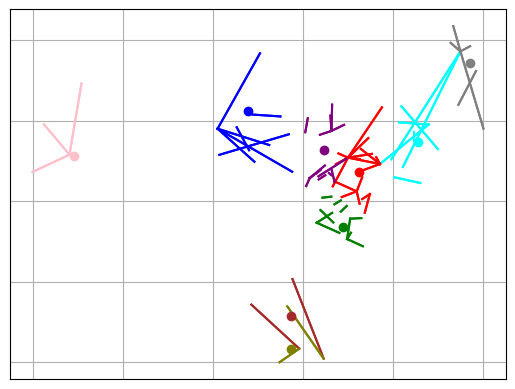

In [ ]:
dataset.link_set.plot_links(scale=True, scale_factor=1.0)
plt.grid()
plt.tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)
plt.show()

In [ ]:
dist_list = []
for i in range(len(dataset.link_set.link_list)):
  link1 = dataset.link_set.link_list[i].meta_data.lon_lat_site_one
  link2 = dataset.link_set.link_list[i].meta_data.lon_lat_site_zero
  gauge_lon = dataset.link_set.link_list[i].gauge_ref.lon
  gauge_lat = dataset.link_set.link_list[i].gauge_ref.lat
  gauge_point = (gauge_lat, gauge_lon)
  line_link = line_to_points(link1 , link2 , 20)
  dataset.link_set.link_list[i].meta_data.distance = average_distance_point_to_line(gauge_point, line_link)
  dist_list.append(average_distance_point_to_line(gauge_point, line_link))
max_distance = max(dist_list)
print(max_distance)

2.5150061290110033


{'frequency': 38.584,
 'polarization': True,
 'length': 1.18227,
 'height_far': None,
 'height_near': None,
 'lon_lat_site_zero': [11.91276, 57.7147],
 'lon_lat_site_one': [11.90373, 57.72416],
 'distance': 1.3782657097518545,
 'xy_zero': array([1317007.04070535,  577828.37943759]),
 'xy_one': array([1316011.12441658,  578861.19563626])}

In [ ]:
training_dataset, validation_dataset = torch.utils.data.random_split(dataset, [0.8, 0.2])
data_loader = torch.utils.data.DataLoader(training_dataset, batch_size)
val_loader = torch.utils.data.DataLoader(validation_dataset, batch_size)

lets get the distances out of the data we imported.

# Compute rain rate statistics
In this section, we compute the rain rate statistics of the dataset. The rain rate statistics are used to understand the distribution of the rain rate in the dataset.
In addition we estimate the parameters of the exponential distribution that fits the rain rate data that will be utilized in later stage to compute a balance loss function.


Rain Rate Statistics
Mean[mm/hr]: 0.10602297037333451
Std[mm/hr]: 0.7062371338958388
Parentage of wet samples 9.006535947712418
Parentage of dry samples 90.99346405228758
Exponential Distribution Parameters: (0.0, 0.10602297037333451)


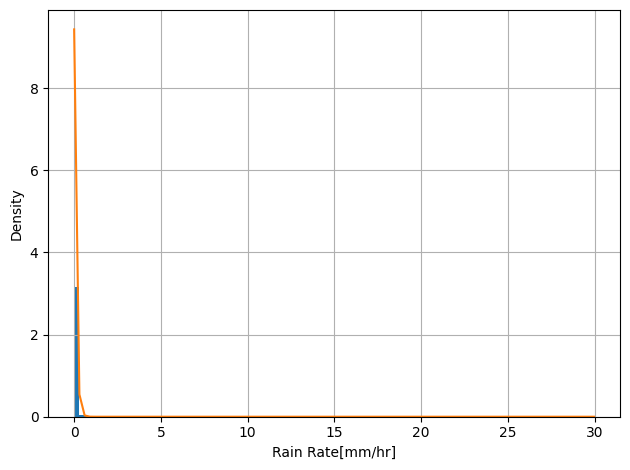

In [ ]:
rg = np.stack([p.data_array for p in dataset.point_set]).flatten()
param = scipy.stats.expon.fit(rg)
exp_gamma = param[1]
print("Rain Rate Statistics")
print("Mean[mm/hr]:", np.mean(rg))
print("Std[mm/hr]:", np.std(rg))
print("Parentage of wet samples", 100 * np.sum(rg > 0) / rg.size)
print("Parentage of dry samples", 100 * np.sum(rg == 0) / rg.size)
print("Exponential Distribution Parameters:", param)
_ = plt.hist(rg, bins=100, density=True)
plt.plot(np.linspace(0, np.max(rg), 100), scipy.stats.expon.pdf(np.linspace(0, np.max(rg), 100), *param))
plt.grid()
plt.xlabel("Rain Rate[mm/hr]")
plt.ylabel("Density")
plt.tight_layout()
plt.show()

# Neural Network

The neural network is constructed using the PyTorch library. The network consists of two main components:
1. RNN: A recurrent neural network that takes the radar signal and the metadata as input and outputs the rain rate.
2. Metadata: A fully connected layer that takes the metadata as input and outputs a feature vector.
The RNN is trained to predict the rain rate at each time step based on the radar signal and the metadata.
3. The network architecture is shown in the figure below:
![Alt text](https://raw.githubusercontent.com//haihabi/PyNNcml/main/images/two_step_network.png )


The network consists of the following components:
1. A backbone that is build of RNN layers that process the CML attenuation and the metadata (shown in blue).
2. A wet/dry classifier that is build of fully connected layers that process backbone feature and produce wet/dry prediction (shown in red).
3. A rain rate estimator that is build of fully connected layers that process backbone feature and produce rain rate prediction (shown in green).






In [ ]:
model = pnc.scm.rain_estimation.two_step_network(n_layers=n_layers,  # Number of RNN layers
                                                 rnn_type=rnn_type,  # Type of RNN (GRU, LSTM)
                                                 normalization_cfg=pnc.training_helpers.compute_data_normalization(
                                                     data_loader),
                                                 # Compute the normalization statistics from the training dataset.
                                                 rnn_input_size=180,  # 90 + 90 (RSL + TSL)
                                                 rnn_n_features=128,  # Number of features in the RNN
                                                 metadata_input_size=3,  # Number of metadata features
                                                 metadata_n_features=32,  # Number of features in the metadata
                                                 pretrained=False).to(
    device)  # Pretrained model is set to False to train the model from scratch.



The loss function used to train the rain estimation model is as follows:
$$J(\Theta)=J_{\mathrm{BCE}}+\lambda J_{\mathrm{Reg}},$$
where $J_{\mathrm{BCE}}$ is a binary cross entropy loss and
$$J_{\mathrm{Reg}}=\sum_{j=1}^{N_b}\sum_{i=1}^{N_s}(1-\exp(\gamma \cdot r_{i,j}))\cdot(\hat{r}_{j,i}-r_{i,j}),$$
is the regression loss function.


In [ ]:
class RegressionLoss(torch.nn.Module):
    def __init__(self, in_gamma):
        super(RegressionLoss, self).__init__()
        self.in_gamma = in_gamma

    def forward(self, input, target, d):
        delta = (target - input) ** 2
        w = 1 - torch.exp(-self.in_gamma * target)
        d = d.unsqueeze(1).expand(-1, input.shape[1])
        return torch.mean((w * delta) / pow(d, 2), dim=0)  # Divide by d per sample

loss_function_rain_est = RegressionLoss(exp_gamma)
loss_function_wet_dry = torch.nn.BCELoss()

# Find lambda values such that at initialization both loss will be equal:
loss_est = 0
loss_detection = 0

with torch.no_grad():
    for rain_rate, rsl, tsl, metadata in data_loader:
        state = model.init_state(batch_size=rsl.shape[0])
        m_step = math.floor(rain_rate.shape[1] / window_size)
        for step in range(m_step):
            _rr = rain_rate[:, step * window_size:(step + 1) * window_size].float().to(device)
            _rsl = rsl[:, step * window_size:(step + 1) * window_size, :].to(device)
            _tsl = tsl[:, step * window_size:(step + 1) * window_size, :].to(device)
            rain_estimation_detection, state = model(torch.cat([_rsl, _tsl], dim=-1), metadata.to(device),
                                                     state.detach())
            rain_hat = rain_estimation_detection[:, :, 0]
            rain_detection = rain_estimation_detection[:, :, 1]
            d = metadata[:, 2].to(device)
            loss_est       += torch.sum(loss_function_rain_est(rain_hat, _rr, d))
            loss_detection += loss_function_wet_dry(rain_detection, (_rr > 0.1).float())

lambda_value = loss_detection / loss_est

# Training Loop

The training loop consists of the following steps:
1. Initialize the optimizer and loss function:
    a. Optimizer: We use the RAdam optimizer with a learning rate of 1e-4 and a weight decay of 1e-4.
    b. Loss Function: We use the Mean Squared Error (MSE) loss function to compute the loss.
2. Iterate over the training dataset and compute the loss.
3. Update the model parameters using the optimizer.
4. Compute the average loss over the training dataset.
5. Repeat the process for a fixed number of epochs.

In [ ]:
opt = torch.optim.RAdam(model.parameters(), lr=lr, weight_decay=1e-4)
ra = pnc.metrics.ResultsAccumulator()
am = pnc.metrics.AverageMetric()

model.train()
print("Start Training")
for epoch in tqdm(range(n_epochs)):
    am.clear()
    for rain_rate, rsl, tsl, metadata in data_loader:
        state = model.init_state(batch_size=rsl.shape[0])
        m_step = math.floor(rain_rate.shape[1] / window_size)
        for step in range(m_step):
            opt.zero_grad()  # Zero gradients
            # Perform sliding window in the CML time series.
            _rr = rain_rate[:, step * window_size:(step + 1) * window_size].float().to(device)
            _rsl = rsl[:, step * window_size:(step + 1) * window_size, :].to(device)
            _tsl = tsl[:, step * window_size:(step + 1) * window_size, :].to(device)
            # Forward pass of the model
            rain_estimation_detection, state = model(torch.cat([_rsl, _tsl], dim=-1), metadata.to(device),
                                                     state.detach())
            rain_hat = rain_estimation_detection[:, :, 0]
            rain_detection = rain_estimation_detection[:, :, 1]
            # Compute loss function
            loss_est = torch.sum(loss_function_rain_est(rain_hat, _rr, metadata[:,2].to(device)))
            loss_detection = loss_function_wet_dry(rain_detection, (_rr > 0.1).float())
            loss = lambda_value * loss_est + loss_detection
            # Take the derivative w.r.t. model parameters $\Theta$
            loss.backward()
            opt.step()
            am.add_results(loss=loss.item(), loss_est=loss_est.item(),
                           loss_detection=loss_detection.item())  # Log results to average.
    ra.add_results(loss=am.get_results("loss"), loss_est=am.get_results("loss_est"),
                   loss_detection=am.get_results("loss_detection"))

Start Training


100%|██████████| 200/200 [1:30:06<00:00, 27.03s/it]


# Analysis of training progress
Here, we plot loss of the model during optimization.

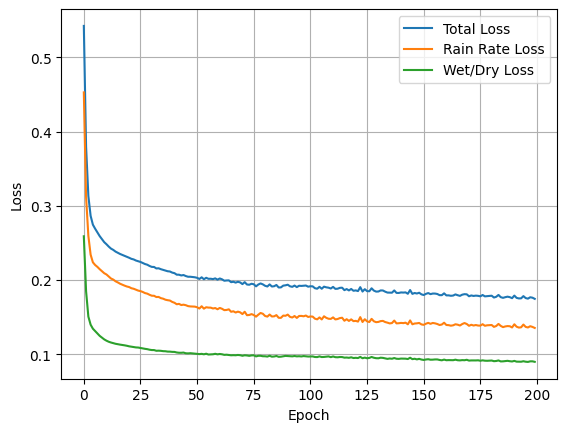

In [ ]:
plt.plot(ra.get_results("loss"), label="Total Loss")
plt.plot(ra.get_results("loss_est"), label="Rain Rate Loss")
plt.plot(ra.get_results("loss_detection"), label="Wet/Dry Loss")
plt.grid()
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

# Model Validation
In this section we validate the neural network quality on the validation datasets. First we provide a statistical results of the trained model which include:
1. Estimation Bias
2. Estimation RMSE
3. Accuracy of Detection
4. Confusion Matrix
5. F1 Score


Secondly we provide some visualization to analyze the model performance.



Mounted at /content/drive
Results Detection:
Validation Results of Two-Step RNN
Accuracy[%]: 96.53378378378379
F1 Score: 0.7362467866323907
Confusion matrix saved to /content/drive/MyDrive/PyNNCML_notebooks/PyNNCML/NN_runs2/NN_model_weights_2_months_RMSE_confusion_matrix.png
Results saved to /content/drive/MyDrive/PyNNCML_notebooks/PyNNCML/NN_runs2/validation_results_model_weights_2_months.txt


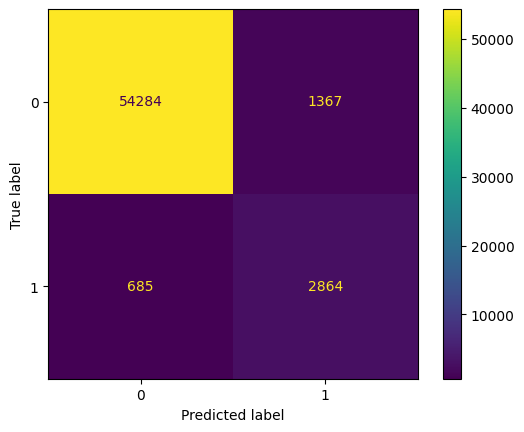

Results Estimation:
-------------------------------------------------- Results Summery --------------------------------------------------
+--------------+------------+--------------+---------------+---------------+---------------+
|    Metric    | 0.0<r<5.99 | 5.99<r<11.98 | 11.98<r<17.98 | 17.98<r<23.97 | 23.97<r<29.96 |
+--------------+------------+--------------+---------------+---------------+---------------+
|     RMSE     |    0.42    |     2.9      |      6.51     |     10.52     |     16.23     |
|     BIAS     |   -0.04    |     1.16     |      4.15     |     10.07     |     15.37     |
|    NRMSE     |    5.7     |     0.38     |      0.46     |      0.5      |      0.58     |
|    NBIAS     |   -0.48    |     0.15     |      0.29     |      0.48     |      0.54     |
| Total Metric |   Value    |      -       |       -       |       -       |       -       |
|     RMSE     |    0.49    |      -       |       -       |       -       |       -       |
|     BIAS     |   -0.03 

In [ ]:
from pynncml.metrics.results_accumlator import GroupAnalysis
from google.colab import drive
import matplotlib.pyplot as plt
from sklearn import metrics
import numpy as np
import os
ra = pnc.metrics.ResultsAccumulator()
am = pnc.metrics.AverageMetric()
drive.mount('/content/drive')
save_path = '' # Add a folder path for your convenience!
model.eval()
ga = GroupAnalysis()
with torch.no_grad():
    for rain_rate, rsl, tsl, metadata in val_loader:
        state = model.init_state(batch_size=rsl.shape[0])
        m_step = math.floor(rain_rate.shape[1] / window_size)
        am.clear()
        rain_ref_list = []
        rain_hat_list = []
        detection_list = []

        for step in range(m_step):
            _rr = rain_rate[:, step * window_size:(step + 1) * window_size].float().to(device)
            _rsl = rsl[:, step * window_size:(step + 1) * window_size, :].to(device)
            _tsl = tsl[:, step * window_size:(step + 1) * window_size, :].to(device)
            rain_estimation_detection, state = model(torch.cat([_rsl, _tsl], dim=-1), metadata.to(device),
                                                     state.detach())
            rain_detection = rain_estimation_detection[:, :, 1]
            rain_hat = rain_estimation_detection[:, :, 0] * torch.round(
                rain_detection)  # Rain Rate is computed only for wet samples
            rain_hat_list.append(rain_hat.detach().cpu().numpy())
            rain_ref_list.append(_rr.detach().cpu().numpy())
            ga.append(rain_ref_list[-1], rain_hat_list[-1])
            detection_list.append(torch.round(rain_detection).detach().cpu().numpy())
            delta = rain_hat.squeeze(dim=-1) - _rr
            bias = torch.mean(delta)
            mse = torch.mean(delta ** 2)
            am.add_results(bias=bias.item(), mse=mse.item())
actual = np.concatenate(detection_list).flatten()
predicted = (np.concatenate(rain_ref_list) > 0.1).astype("float").flatten()
confusion_matrix = metrics.confusion_matrix(actual, predicted)
max_rain = np.max(np.concatenate(rain_ref_list))
g_array = np.linspace(0, max_rain, 6)

print("Results Detection:")
print("Validation Results of Two-Step RNN")
print("Accuracy[%]:", 100 * (np.sum(actual == predicted) / actual.size))
print("F1 Score:", metrics.f1_score(actual, predicted))

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=[0, 1])


# Assuming you have already mounted Google Drive
fig_name = f"NN_RMSE_confusion_matrix.png"
file_name = f"validation_results.txt"
save_path_cm = save_path + fig_name
save_path_txt = save_path + file_name

os.makedirs(os.path.dirname(save_path_cm), exist_ok=True)

# Save confusion matrix as an image
cm_display.plot()
plt.savefig(save_path_cm)
plt.close()  # Close the plot to avoid displaying it again

# Save accuracy and F1 score to a text file
accuracy = 100 * (np.sum(actual == predicted) / actual.size)
f1_score = metrics.f1_score(actual, predicted)

with open(save_path_txt, 'w') as f:
    f.write(f"Validation Results of Two-Step RNN\n")
    f.write(f"Accuracy[%]: {accuracy:.8f}\n")
    f.write(f"F1 Score: {f1_score:.8f}\n")

print(f"Confusion matrix saved to {save_path_cm}")
print(f"Results saved to {save_path_txt}")



cm_display.plot()
plt.show()

print("Results Estimation:")
_ = ga.run_analysis(np.stack([g_array[:-1], g_array[1:]], axis=-1))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


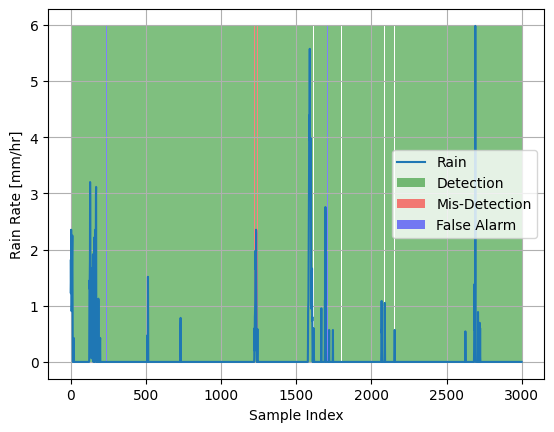

Figure saved to: /content/drive/MyDrive/PyNNCML_notebooks/PyNNCML/NN_runs2/NN_model_weights_2_months_Detection_plot.png


In [ ]:
fig_name = f"NN_Detection_plot.png"

os.makedirs(save_path, exist_ok=True)

detection_array = np.concatenate(detection_list, axis=1)
rain_ref_array = np.concatenate(rain_ref_list, axis=1)
detection_array = np.round(detection_array)

rain_array = rain_ref_array[5, :3000]
detection_array = detection_array[5, :3000]
fig, ax = plt.subplots()
x = np.arange(rain_array.shape[0])
ax.plot(x, rain_array, label="Rain")
rain_max = np.max(rain_array)
ax.fill_between(x, rain_max, where=np.logical_or(np.logical_and(detection_array == 1, rain_array > 0),
                                                 np.logical_and(detection_array == 0, rain_array == 0)),
                facecolor='green', alpha=.5, label="Detection")
ax.fill_between(x, rain_max, where=np.logical_and(detection_array == 0, rain_array > 0), facecolor='red',
                alpha=.5, label="Mis-Detection")
ax.fill_between(x, rain_max, where=np.logical_and(detection_array == 1, rain_array == 0), facecolor='blue',
                alpha=.5, label="False Alarm")
plt.legend()
plt.ylabel("Rain Rate [mm/hr]")
plt.xlabel("Sample Index")
plt.grid()

fig_filename = os.path.join(save_path, fig_name)
plt.savefig(fig_filename, dpi=300, bbox_inches='tight')
plt.show()

print(f"Figure saved to: {fig_filename}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


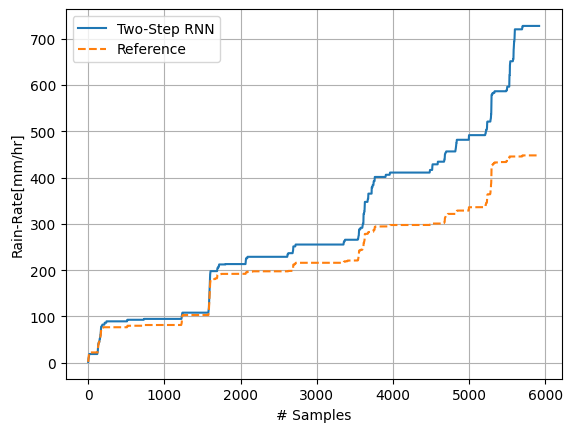

Figure saved to: /content/drive/MyDrive/PyNNCML_notebooks/PyNNCML/NN_runs2/NN_model_weights_2_months_tracking_plot.png


In [ ]:
fig_name = f"NN_tracking_plot.png"

os.makedirs(save_path, exist_ok=True)

rain_hat_array = np.concatenate(rain_hat_list, axis=1)
rain_ref_array = np.concatenate(rain_ref_list, axis=1)

plt.plot(np.cumsum(np.maximum(rain_hat_array[5, :], 0)), label="Two-Step RNN")
plt.plot(np.cumsum(rain_ref_array[5, :]), "--", label="Reference")
plt.grid()
plt.legend()
plt.ylabel("Rain-Rate[mm/hr]")
plt.xlabel("# Samples")

fig_filename = os.path.join(save_path, fig_name)
plt.savefig(fig_filename, dpi=300, bbox_inches='tight')
plt.show()

print(f"Figure saved to: {fig_filename}")

In [ ]:
# Now we want to save the NN
from google.colab import files
torch.save(model.state_dict(), "model_weights.pth")
files.download("model_weights.pth")  # Change filename if needed

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# References

[1] Habi, Hai Victor, and Hagit Messer. "Recurrent neural network for rain estimation using commercial microwave links." IEEE Transactions on Geoscience and Remote Sensing 59.5 (2020): 3672-3681.